# PCA de importações de Santos

## Setup

### Importações

In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [359]:
dict_dtypes = pd.read_pickle("datasets/aux_carga_dtypes.pkl").to_dict()

In [360]:
df = pd.read_csv("datasets/df_rus_ua_psantos.csv", decimal=",", dtype=dict_dtypes)

### Limpeza

In [361]:
df.columns

Index(['IDCarga', 'IDAtracacao', 'Origem', 'Destino', 'CDMercadoria',
       'Tipo Operação da Carga', 'Carga Geral Acondicionamento',
       'ConteinerEstado', 'Tipo Navegação', 'FlagAutorizacao', 'FlagCabotagem',
       'FlagCabotagemMovimentacao', 'FlagConteinerTamanho', 'FlagLongoCurso',
       'FlagMCOperacaoCarga', 'FlagOffshore', 'FlagTransporteViaInterioir',
       'Percurso Transporte em vias Interiores',
       'Percurso Transporte Interiores', 'STNaturezaCarga', 'STSH2', 'STSH4',
       'Natureza da Carga', 'Sentido', 'TEU', 'QTCarga', 'VLPesoCargaBruta',
       'Ano'],
      dtype='object')

In [362]:
df.drop(["IDAtracacao",
         "Destino",
         "Sentido",
         "Carga Geral Acondicionamento",
         "ConteinerEstado",
         "FlagConteinerTamanho"], axis=1, inplace=True)

### Junção de Carga com Carga Conteinerizada

In [363]:
df_mestre = df.copy()
for ano in range(df["Ano"].min(), df["Ano"].max() + 1):
    print("Ano atual: ", ano)
    df_cont = pd.read_csv(f"/home/vortex/Documents/Fatec/Trabalhos/Projeto Integrador local/BD/ANTAQ/{ano}Carga_Conteinerizada.csv", sep=";", decimal=",", dtype=dict_dtypes)

    df_mestre = df_mestre.merge(df_cont,"left", "IDCarga")

    # Combinação
    df_mestre["VLPesoCargaBruta"] = df_mestre["VLPesoCargaConteinerizada"].combine_first(df_mestre["VLPesoCargaBruta"])
    df_mestre.drop("VLPesoCargaConteinerizada", axis=1, inplace=True)
    df_mestre["CDMercadoria"] = df_mestre["CDMercadoriaConteinerizada"].combine_first(df_mestre["CDMercadoria"])
    df_mestre.drop("CDMercadoriaConteinerizada", axis=1, inplace=True)

del df_cont
del df

Ano atual:  2018
Ano atual:  2019
Ano atual:  2020
Ano atual:  2021
Ano atual:  2022
Ano atual:  2023


Variáveis auxiliares

In [364]:
ano_min = df_mestre["Ano"].min()
ano_max = df_mestre["Ano"].max()

## Junção de Carga com Mercadoria

Alternativa seria pegar apenas os dois primeiros digitos de `CDMercadoria`

In [365]:
df_merc = pd.read_csv("/home/vortex/Documents/Fatec/Trabalhos/Projeto Integrador local/BD/ANTAQ/Mercadoria.csv", sep=";")

In [366]:
df_mestre = df_mestre.merge(df_merc.loc[:, ["CDMercadoria", "CDNCMSH2"]], on="CDMercadoria")

In [367]:
df_mestre.drop("CDMercadoria", axis=1, inplace=True)

### Categorização

In [368]:
df_cat = df_mestre.copy()

In [369]:
for col in df_cat:
    if df_cat[col].dtype == "category":
        df_cat[col] = df_cat[col].cat.codes
    if df_cat[col].dtype == "object":
        df_cat[col] = df_cat[col].astype("category").cat.codes

In [370]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10786 entries, 0 to 10785
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   IDCarga                                 10786 non-null  int64  
 1   Origem                                  10786 non-null  int8   
 2   Tipo Operação da Carga                  10786 non-null  int8   
 3   Tipo Navegação                          10786 non-null  int8   
 4   FlagAutorizacao                         10786 non-null  int8   
 5   FlagCabotagem                           10786 non-null  boolean
 6   FlagCabotagemMovimentacao               10786 non-null  boolean
 7   FlagLongoCurso                          10786 non-null  boolean
 8   FlagMCOperacaoCarga                     10786 non-null  boolean
 9   FlagOffshore                            10786 non-null  boolean
 10  FlagTransporteViaInterioir              10786 non-null  bo

In [371]:
df_cat.drop("IDCarga",axis=1, inplace=True)

In [372]:
df_cat = df_cat.fillna(0)

### Mudanças interativas

#### Retirada de colunas

In [373]:
# df_cat.drop(["STSH2", "STSH4", "STNaturezaCarga", "Natureza da Carga"],axis=1, inplace=True)

Grandes mudanças

#### Porto para país

In [375]:
# df_mestre["Origem"] = df_mestre["Origem"].str[:2]

Zero mudanças

### Normalização dos dados

In [376]:
normalizador = StandardScaler()

In [377]:
arr_cat_norm = normalizador.fit_transform(df_cat)

## PCA

### Estimador e projeção

In [378]:
pca = PCA()

In [379]:
df_proj = pd.DataFrame(pca.fit_transform(arr_cat_norm), columns=pca.get_feature_names_out())

### Influência nas colunas do PCA

In [380]:
df_comp = pd.DataFrame(pca.components_, pca.get_feature_names_out(), df_cat.columns)

Maior influência em pca0

In [381]:
df_comp.loc[:"pca0",df_comp.loc["pca0"].abs().sort_values(ascending=False).index]

,Natureza da Carga,Ano,VLPesoCargaBruta,CDNCMSH2,TEU,Origem,Tipo Operação da Carga,QTCarga,STNaturezaCarga,STSH4,Tipo Navegação,FlagCabotagem,FlagOffshore,FlagTransporteViaInterioir,FlagLongoCurso,FlagMCOperacaoCarga,Percurso Transporte Interiores,FlagCabotagemMovimentacao,FlagAutorizacao,Percurso Transporte em vias Interiores
pca0,0.586165,0.42637,0.368569,-0.360674,-0.353216,-0.235525,0.099246,-0.090798,0.078894,-0.064331,2.220446e-16,-1.387779e-17,6.776264e-21,-2.117582e-22,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


Maior influência em pca1

In [382]:
df_comp.loc["pca1":"pca1",df_comp.loc["pca1"].abs().sort_values(ascending=False).index]

,STSH4,STNaturezaCarga,Origem,QTCarga,CDNCMSH2,Tipo Operação da Carga,TEU,Natureza da Carga,Ano,VLPesoCargaBruta,FlagCabotagemMovimentacao,FlagAutorizacao,FlagLongoCurso,FlagOffshore,FlagTransporteViaInterioir,FlagMCOperacaoCarga,Percurso Transporte Interiores,FlagCabotagem,Tipo Navegação,Percurso Transporte em vias Interiores
pca1,-0.701529,-0.695895,-0.095192,0.092026,0.050643,0.038212,0.035324,0.018385,0.015304,0.014534,-2.220446e-16,-5.551115e-17,-1.387779e-17,8.673617e-19,-5.421011e-20,0.0,0.0,0.0,0.0,0.0


Maior influência em pca2

In [383]:
df_comp.loc["pca2":"pca2",df_comp.loc["pca2"].abs().sort_values(ascending=False).index]

,TEU,Origem,QTCarga,Tipo Operação da Carga,CDNCMSH2,VLPesoCargaBruta,Ano,STNaturezaCarga,Natureza da Carga,STSH4,FlagCabotagemMovimentacao,FlagAutorizacao,Tipo Navegação,FlagMCOperacaoCarga,FlagTransporteViaInterioir,FlagLongoCurso,FlagOffshore,FlagCabotagem,Percurso Transporte Interiores,Percurso Transporte em vias Interiores
pca2,0.521304,-0.506736,0.434635,0.348607,-0.311942,0.163947,-0.137101,0.088737,-0.081978,0.058727,1.110223e-16,-1.110223e-16,-1.110223e-16,-6.938894e-18,1.301043e-18,-0.0,-0.0,-0.0,-0.0,-0.0


Um gráfico 3D pra ver a distribuição de carganão seria má ideia

# Plotagem

## Colorido por ano

### Geral

Sem padrão discernível

In [384]:
x_col = "Ano"

In [385]:
df_mestre[x_col].unique().tolist()

[2018, 2019, 2020, 2021, 2022, 2023]

In [386]:
x_estilos = {
    2018: ('#1f77b4', 'o'),
    2019: ('#ff7f0e', 's'),
    2020: ('#2ca02c', 'v'),
    2021: ('#d62728', '^'),
    2022: ('#9467bd', 'D'),
    2023: ('#8c564b', 'P')
}

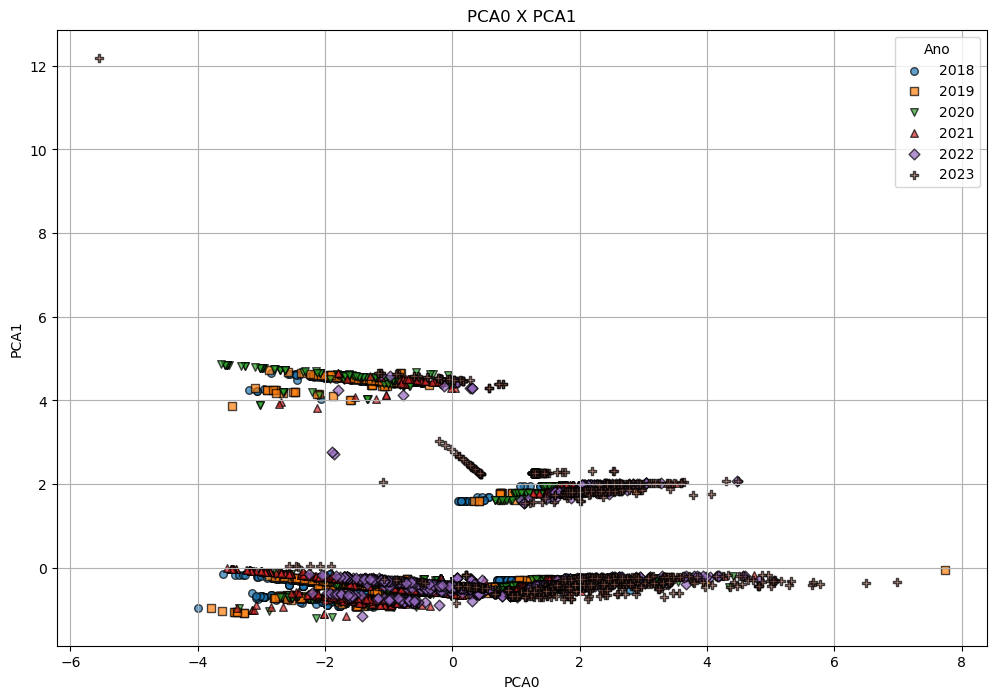

In [387]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_proj[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend(title="Ano")
plt.show()

## Colorido por país

In [388]:
x_col = "Origem"

In [389]:
df_mestre[x_col].unique().tolist()

['RU006',
 'RULED',
 'RUNVS',
 'UAILK',
 'UAODS',
 'RUTUA',
 'UAYUZ',
 'RUKRR',
 'RUZZZ',
 'RUMMK',
 'RUKGD',
 'RUPRI',
 'RUVVO',
 'RUKAV']

In [390]:
x_estilos = {
    'RU': ('#1f77b4', 'o'),
    'UA': ('#ff7f0e', 's')
}

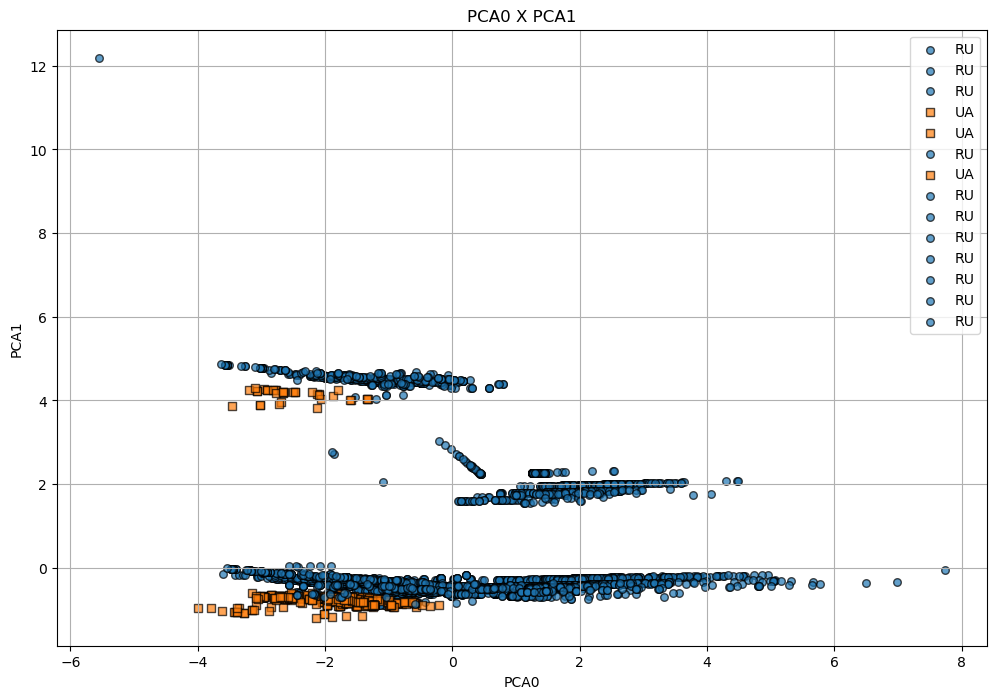

In [391]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for porto in df_mestre[x_col].unique().tolist():
    x_ = porto[:2]
    (cor, marker) = x_estilos[x_]
    subset = df_proj[df_mestre[x_col] == porto]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend()
plt.show()

### Colorido por Natureza de Carga

In [392]:
x_col = "Natureza da Carga"

In [393]:
df_mestre[x_col].unique().tolist()

['Granel Sólido',
 'Carga Conteinerizada',
 'Carga Geral',
 'Granel Líquido e Gasoso']

In [394]:
x_estilos = {
    'Granel Sólido': ('#1f77b4', 'o'),
    'Carga Conteinerizada': ('#ff7f0e', 's'),
    'Carga Geral': ('#2ca02c', 'v'),
    'Granel Líquido e Gasoso': ('#d62728', '^')
}

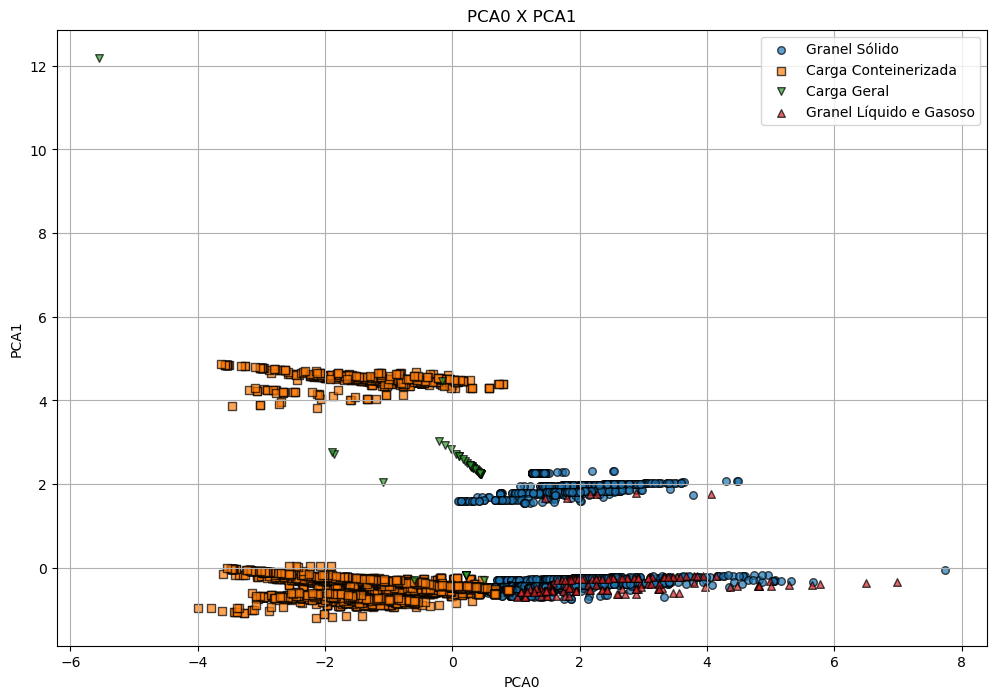

In [395]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_proj[df_mestre[x_col] == x_]
    # if x_ != "Granel Sólido":
    #     continue
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend()
plt.show()

Relação com ano e tipo de carga?

## Gradiente por capítulo de mercadoria

Normaliza-se os códigos do CDMercadoria

In [396]:
norm_codes = plt.Normalize(df_cat['CDNCMSH2'].min(), df_cat['CDNCMSH2'].max())

In [397]:
len(df_mestre['CDNCMSH2'].unique().tolist())

65

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


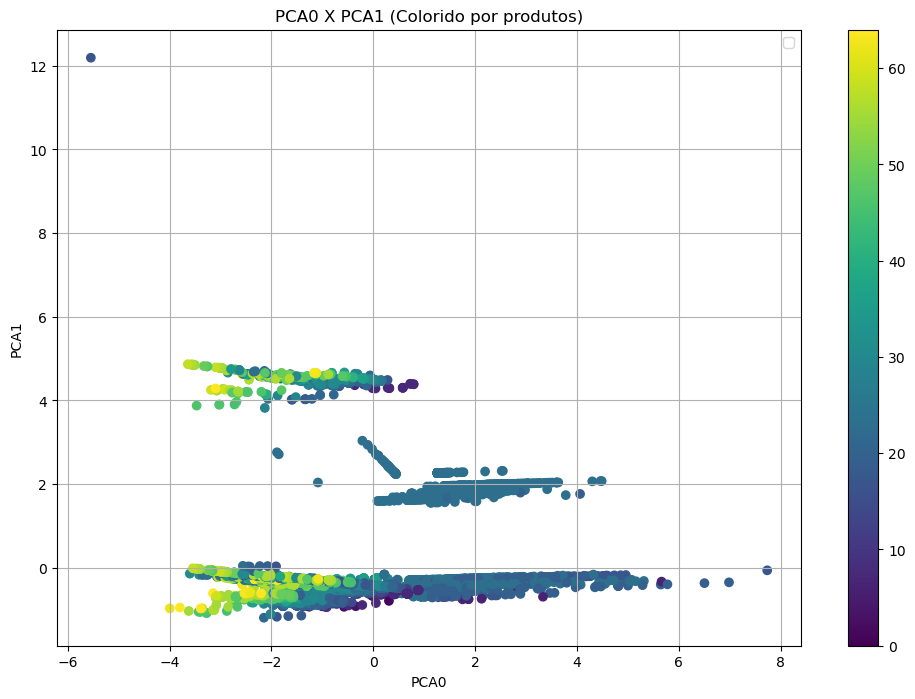

In [398]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1 (Colorido por produtos)")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

scatter = plt.scatter(
    df_proj['pca0'], df_proj['pca1'],
    c=df_cat['CDNCMSH2'], cmap='viridis', norm=norm_codes
)

cbar = plt.colorbar(scatter)
cd_mercs = df_mestre['CDNCMSH2'].unique().tolist()
# cbar.set_ticks(range(0, len(cd_mercs), 5))
# cbar.set_ticklabels(cd_mercs[0::5])

plt.legend()
plt.show()

Sem padrão claro

## Gradiente por Origem

In [399]:
norm_codes = plt.Normalize(df_cat['Origem'].min(), df_cat['Origem'].max())

In [400]:
cat_origem = df_mestre["Origem"].astype("category").cat.categories

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


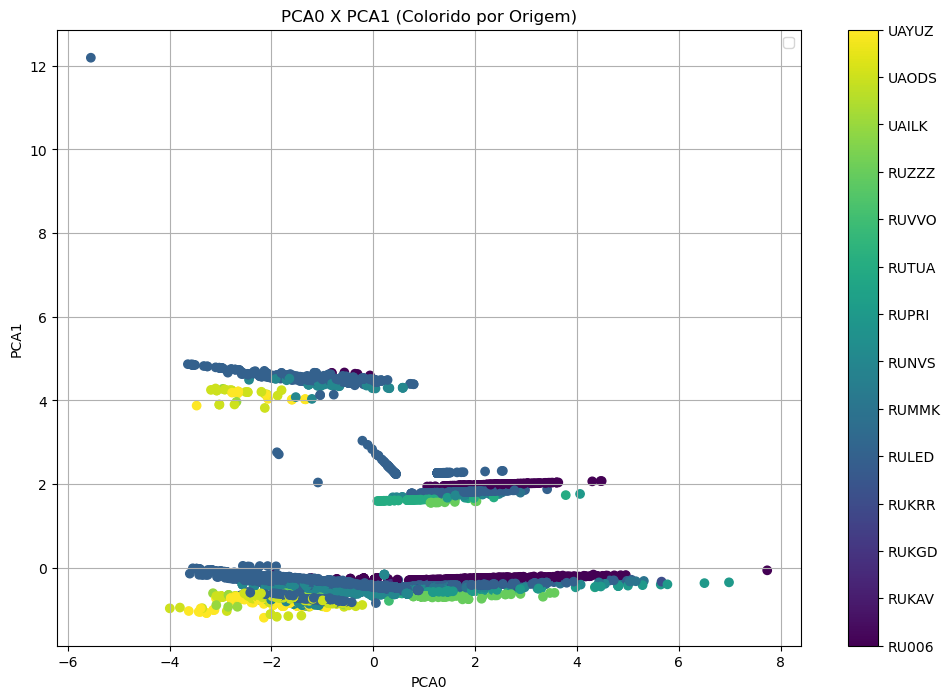

In [401]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1 (Colorido por Origem)")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

scatter = plt.scatter(
    df_proj['pca0'], df_proj['pca1'],
    c=df_cat['Origem'], cmap='viridis', norm=norm_codes
)

cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(cat_origem)))
cbar.set_ticklabels(cat_origem)

plt.legend()
plt.show()

## Por STs

### Colorido por STSH2

In [402]:
x_col = "STSH2"

In [403]:
df_mestre[x_col].unique().tolist()

['Exclusivo', 'Compartilhado']

In [404]:
x_estilos = {
    'Exclusivo': ('#1f77b4', 'o'),
    'Compartilhado': ('#ff7f0e', 's')
}

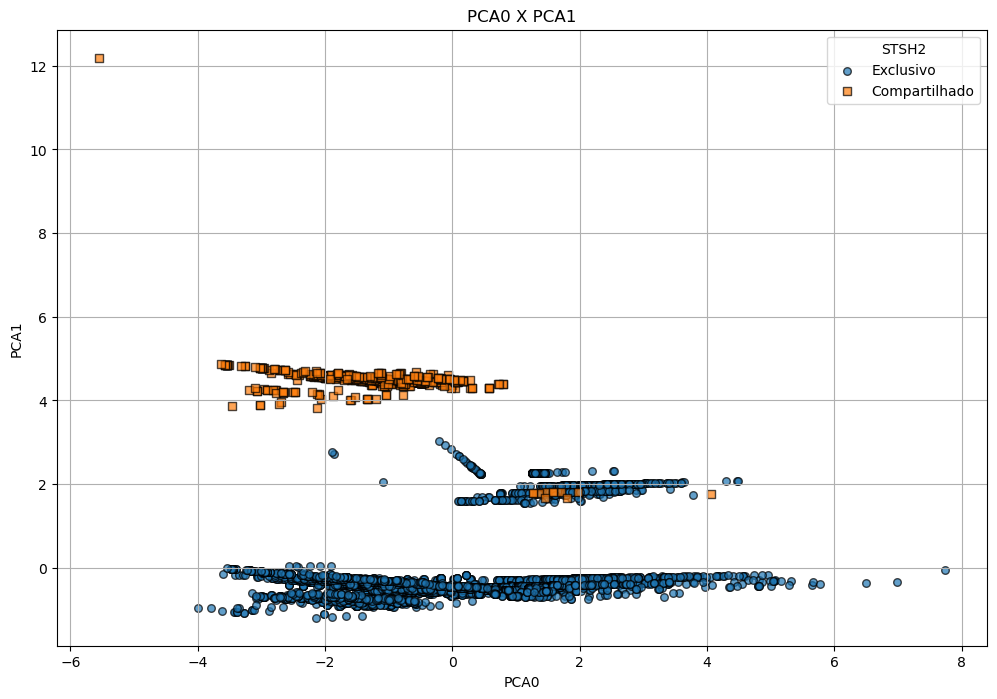

In [405]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_proj[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend(title="STSH2")
plt.show()

In [406]:
df_mestre["STSH2"].cat.codes

0        1
1        1
2        1
3        1
4        1
        ..
10781    1
10782    1
10783    1
10784    1
10785    1
Length: 10786, dtype: int8

### Colorido por STNaturezaCarga

In [407]:
x_col = "STNaturezaCarga"

In [408]:
df_mestre[x_col].unique().tolist()

['Exclusivo', 'Compartilhado']

In [409]:
x_estilos = {
    'Exclusivo': ('#1f77b4', 'o'),
    'Compartilhado': ('#ff7f0e', 's')
}

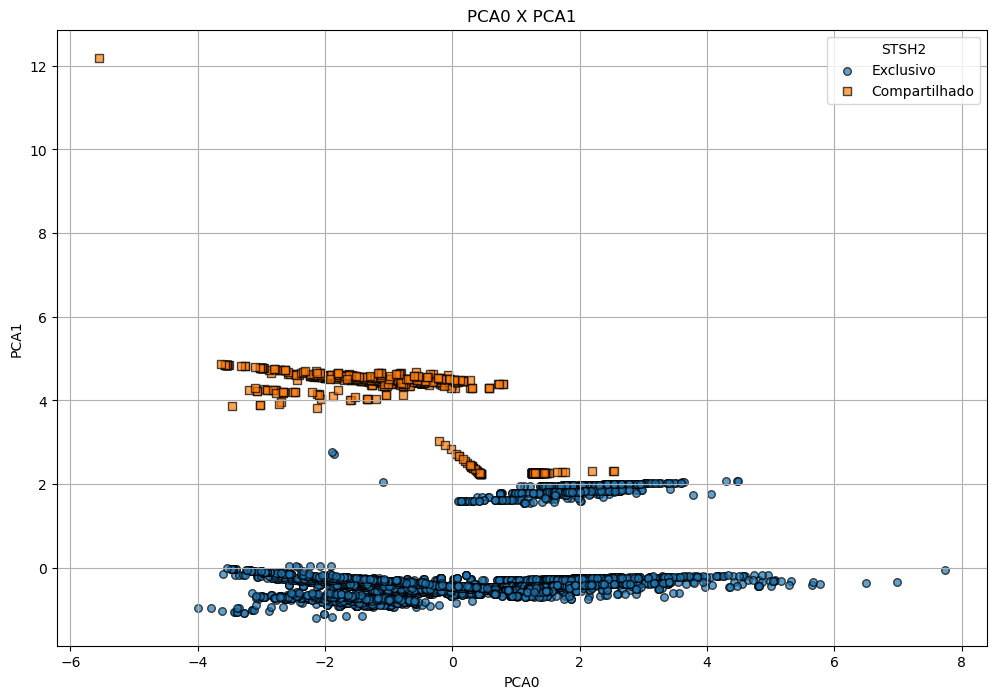

In [410]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_proj[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend(title="STSH2")
plt.show()

### Colorido por STSH4

In [411]:
x_col = "STSH4"

In [412]:
df_mestre[x_col].unique().tolist()

['Exclusivo', 'Compartilhado']

In [413]:
x_estilos = {
    'Exclusivo': ('#1f77b4', 'o'),
    'Compartilhado': ('#ff7f0e', 's')
}

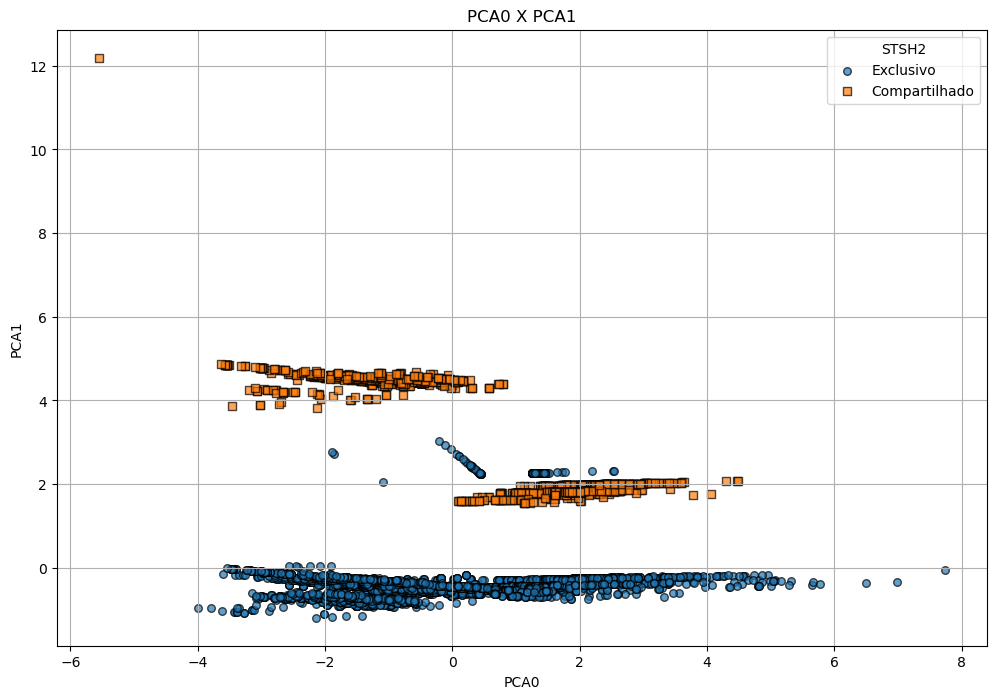

In [414]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_proj[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend(title="STSH2")
plt.show()

## Gradiente por Peso de Carga Bruta

In [415]:
norm_codes = plt.Normalize(df_cat['VLPesoCargaBruta'].min(), df_cat['VLPesoCargaBruta'].max())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


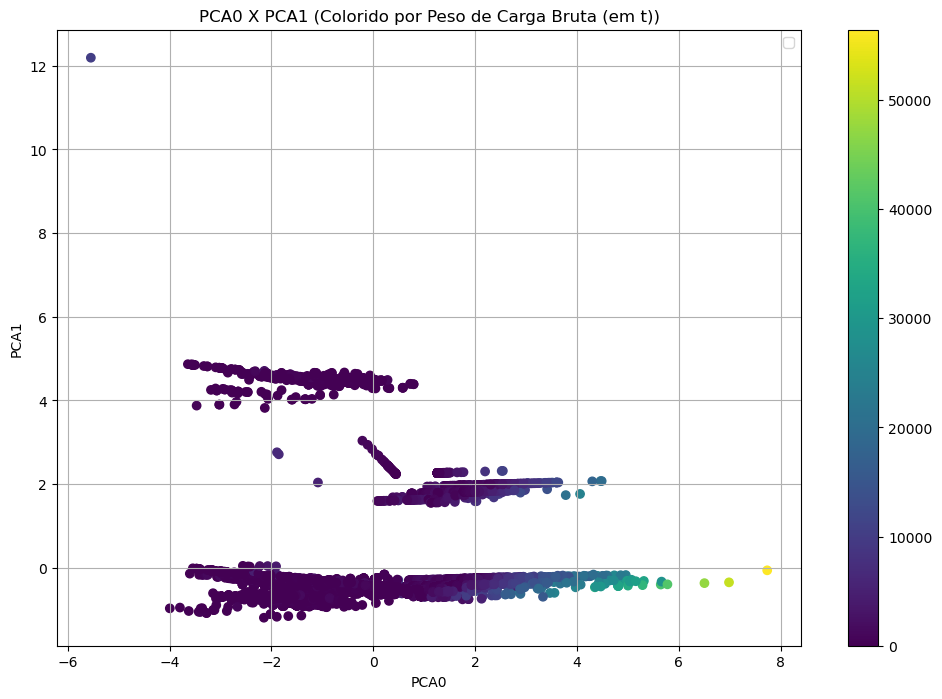

In [416]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1 (Colorido por Peso de Carga Bruta (em t))")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

scatter = plt.scatter(
    df_proj['pca0'], df_proj['pca1'],
    c=df_cat['VLPesoCargaBruta'], cmap='viridis', norm=norm_codes
)

cbar = plt.colorbar(scatter)

plt.legend()
plt.show()

## Produtos mais típicos

### Mais típico por `pca0` e `pca1`

Produtos com menor variância (por pca0 e pca1)

In [417]:
ds = np.linalg.norm(df_proj.loc[:,["pca0", "pca1"]], axis=1)

indice_tipico = np.argmin(ds)
elemento_tipico = df_mestre.iloc[indice_tipico]

In [418]:
elemento_tipico

IDCarga                                                 31006306
Origem                                                     RU006
Tipo Operação da Carga                    Longo Curso Importação
Tipo Navegação                                       Longo Curso
FlagAutorizacao                                                S
FlagCabotagem                                              False
FlagCabotagemMovimentacao                                  False
FlagLongoCurso                                              True
FlagMCOperacaoCarga                                         True
FlagOffshore                                               False
FlagTransporteViaInterioir                                 False
Percurso Transporte em vias Interiores                       NaN
Percurso Transporte Interiores                               NaN
STNaturezaCarga                                        Exclusivo
STSH2                                                  Exclusivo
STSH4                    

### Produto mais típico em geral

Produtos com menor variância (por todas colunas)

In [419]:
ds = np.linalg.norm(df_proj, axis=1)

indice_tipico = np.argmin(ds)
elemento_tipico = df_mestre.iloc[indice_tipico]

In [420]:
elemento_tipico

IDCarga                                                 27813613
Origem                                                     RULED
Tipo Operação da Carga                    Longo Curso Importação
Tipo Navegação                                       Longo Curso
FlagAutorizacao                                                S
FlagCabotagem                                              False
FlagCabotagemMovimentacao                                  False
FlagLongoCurso                                              True
FlagMCOperacaoCarga                                         True
FlagOffshore                                               False
FlagTransporteViaInterioir                                 False
Percurso Transporte em vias Interiores                       NaN
Percurso Transporte Interiores                               NaN
STNaturezaCarga                                        Exclusivo
STSH2                                                  Exclusivo
STSH4                    

### Produtos mais típicos ano a ano

In [421]:
elemento_tipico_anox = []
indexes_tipicos = []
for ano in range(ano_min, ano_max + 1):# plt.scatter(df_proj['pca0'], df_proj['pca1'], color=cor, alpha=0.7, edgecolor='k', s=30)

    df_mestre_anual = df_mestre[df_mestre["Ano"] == ano]
    ds = np.linalg.norm(df_proj[df_mestre["Ano"] == ano], axis=1)

    indice_tipico = np.argmin(ds)
    elemento_tipico_anox.append(df_mestre_anual.iloc[indice_tipico])
    indexes_tipicos.append(df_mestre_anual.index[indice_tipico])

In [422]:
x_estilos = {
    2018: ('#1f77b4', 'o'),
    2019: ('#ff7f0e', 's'),
    2020: ('#2ca02c', 'v'),
    2021: ('#d62728', '^'),
    2022: ('#9467bd', 'D'),
    2023: ('#8c564b', 'P')
}

In [423]:
df_mestre.loc[indexes_tipicos]

,IDCarga,Origem,Tipo Operação da Carga,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,...,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,TEU,QTCarga,VLPesoCargaBruta,Ano,CDNCMSH2
124,21109674,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,22.0,11,45.33,2018,34
1630,24003424,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,24.0,12,6.32,2019,34
3998,27052976,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,20.0,10,3.73,2020,34
4795,27813613,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,30.0,30,38.19,2021,34
7613,30831683,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,32.0,16,463.77,2022,31
9048,33880788,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,10.0,5,18.12,2023,38


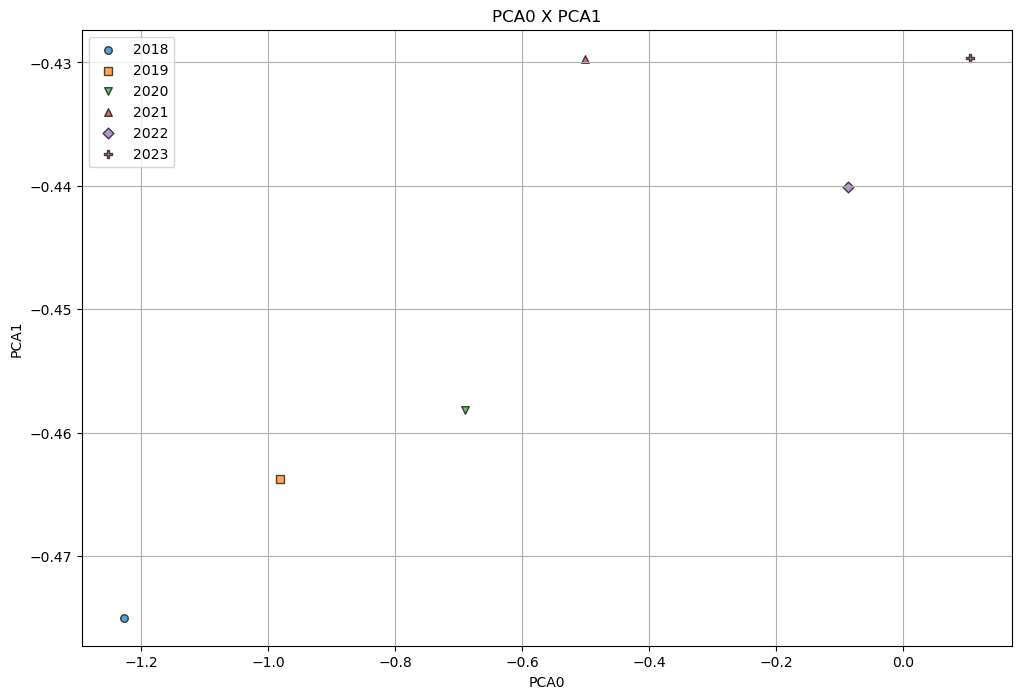

In [424]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
cor = []
marker = []
for ano, (cor, marker) in x_estilos.items():
    index_ano = df_mestre.loc[indexes_tipicos]
    index_ano = index_ano.index[index_ano["Ano"] == ano]
    plt.scatter(df_proj['pca0'].loc[index_ano], df_proj['pca1'].loc[index_ano], marker=marker, color=cor, label=str(ano), alpha=0.7, edgecolor='k', s=30)

plt.legend()
plt.show()

Ano com menor variância é 2019

Com o passar dos anos houve uma mudança na natureza/tipo da carga típica movimenta